In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import json
import warnings

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
dataset_map = {
    '1': 'Energy',
    '2': 'Stock',
    '3': 'Traffic',
    '4': 'Weather'
}
dataset_choice = input("Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather): ")
selected_dataset = dataset_map.get(dataset_choice)

Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather):  2


In [4]:
base_models = ['LSTM', 'Transformer', 'LiquidML', 'XGBoost']
selected_models = []
for model in base_models:
    choice = input(f"Include {model} in ensemble? (y/n): ")
    if choice.lower() == 'y':
        selected_models.append(model)

Include LSTM in ensemble? (y/n):  y
Include Transformer in ensemble? (y/n):  y
Include LiquidML in ensemble? (y/n):  y
Include XGBoost in ensemble? (y/n):  y


In [5]:
dataset_files = {
    'Energy': '../datasets/AEP_hourly_processed.xlsx',
    'Stock': '../datasets/Tesla_Stock.xlsx',
    'Traffic': '../datasets/traffic.xlsx',
    'Weather': '../datasets/jena_climate.xlsx'
}
selected_file = dataset_files[selected_dataset]

In [6]:
X_train_meta, X_test_meta = [], []

for model in selected_models:
    X_train_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_train.npy").reshape(-1))
    X_test_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_test.npy").reshape(-1))

X_train_meta = np.stack(X_train_meta, axis=1)
X_test_meta = np.stack(X_test_meta, axis=1)

In [7]:
df = pd.read_excel(selected_file)

if selected_dataset == "Energy":
    df = df.iloc[:5000]
    target_column = "AEP_MW"
elif selected_dataset == "Stock":
    df = df.iloc[-2000:]
    target_column = "Close"
elif selected_dataset == "Traffic":
    df = df.iloc[-3000:]
    target_column = "Vehicles"
else:
    df = df.iloc[::144]
    target_column = "Tpot (K)"

full_target = df[target_column].values
split_idx = int(len(full_target) * 0.8)
y_train = full_target[:split_idx][60:]
y_test = full_target[split_idx:][60:]

In [8]:
meta_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_meta_scaled = meta_scaler.fit_transform(X_train_meta)
X_test_meta_scaled = meta_scaler.transform(X_test_meta)

y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

ensemble_preds_train_scaled = X_train_meta_scaled.mean(axis=1)
ensemble_preds_test_scaled = X_test_meta_scaled.mean(axis=1)


ensemble_preds_train = target_scaler.inverse_transform(ensemble_preds_train_scaled.reshape(-1, 1)).flatten()
ensemble_preds_test = target_scaler.inverse_transform(ensemble_preds_test_scaled.reshape(-1, 1)).flatten()

In [9]:
ensemble_rmse_train = mean_squared_error(y_train, ensemble_preds_train, squared=False)
ensemble_rmse_test = mean_squared_error(y_test, ensemble_preds_test, squared=False)

print(f"Voting Ensemble RMSE (Train): {ensemble_rmse_train:.4f}")
print(f"Voting Ensemble RMSE (Test):  {ensemble_rmse_test:.4f}")

Voting Ensemble RMSE (Train): 38.1135
Voting Ensemble RMSE (Test):  11.0844


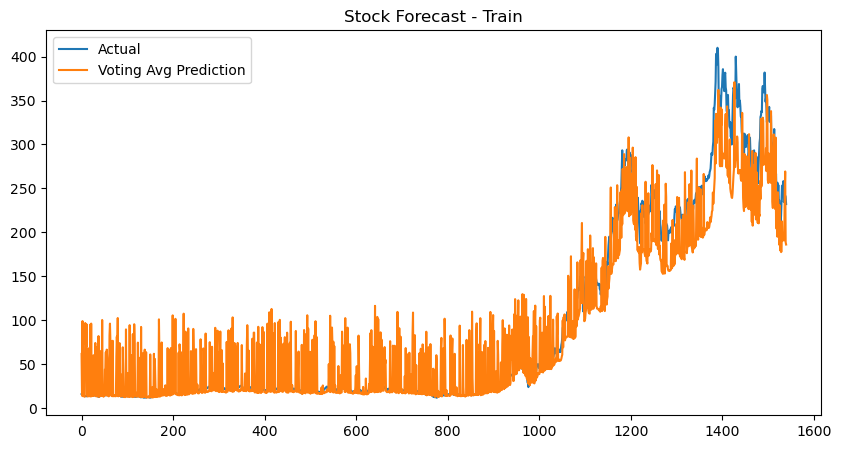

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, label="Actual")
plt.plot(ensemble_preds_train, label="Voting Avg Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Train")
plt.legend()
plt.show()

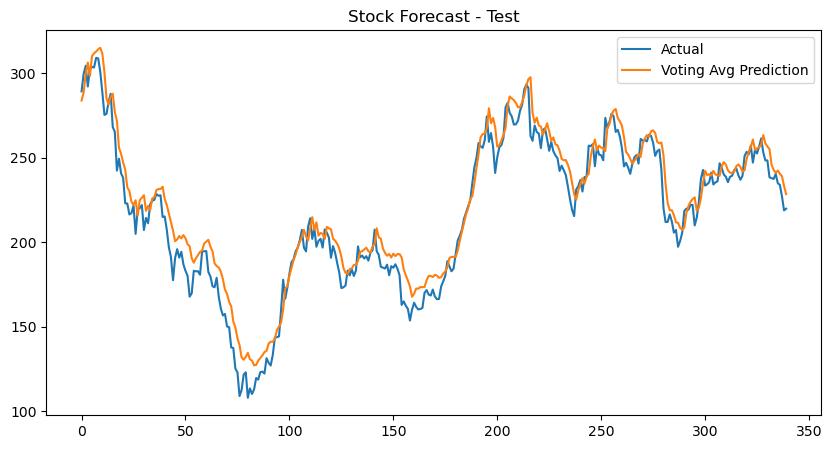

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(ensemble_preds_test, label="Voting Avg Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Test")
plt.legend()
plt.show()

In [12]:
model_rmses = []
for model in selected_models:
    with open(f"../{model}/RMSE_{model}.json", "r") as f:
        rmse_data = json.load(f)
    model_rmses.append(rmse_data[selected_dataset])

model_rmses.append(ensemble_rmse_test)

labels = selected_models + ['Voting']

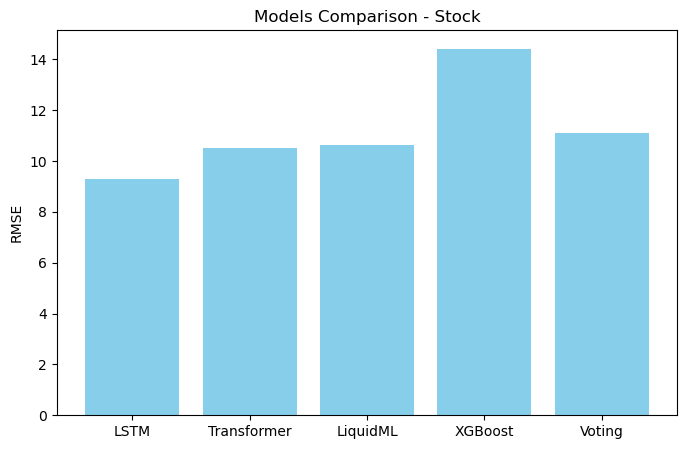

In [13]:
plt.figure(figsize=(8, 5))
plt.bar(labels, model_rmses, color='skyblue')
plt.title(f"Models Comparison - {selected_dataset.title()}")
plt.ylabel("RMSE")
plt.show()